In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
csv_path = 'script_csv/'
male_dialogue = []
female_dialogue = []
for filename in os.listdir(csv_path):
    if filename.endswith('.csv'):
        df = pd.read_csv(csv_path + filename)
        for index, row in df.iterrows():
            if row['gender'] == 'MALE':
                male_dialogue.append(row['line'])
            elif row['gender'] == 'FEMALE':
                female_dialogue.append(row['line'])

print(len(male_dialogue),len(female_dialogue))


10872 2938


In [5]:
csv_iron_man = 'script_csv/iron_man.csv'
male_iron = []
female_iron = []
df = pd.read_csv(csv_path + filename)
for index, row in df.iterrows():
    if row['gender'] == 'MALE':
        male_iron.append(row['line'])
    elif row['gender'] == 'FEMALE':
        female_iron.append(row['line'])
print(len(male_iron),len(female_iron))

622 216


In [2]:
df = pd.read_csv("/kaggle/input/twitter-dataset/gender_classifier.csv")
# take only 2 columns gender and tweet
df = df[['gender', 'text']]
df.head()
print(df['gender'].value_counts())

gender
female     6700
male       6194
brand      5942
unknown    1117
Name: count, dtype: int64


In [3]:
def clean_test(text):
    # remove all non-ascii characters
    # remove all the specials characters
    special_chars = "!#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    for i in text:
        if i in special_chars:
            text = text.replace(i, ' ')
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

df['text'] = df['text'].apply(clean_test)
df.head()

,gender,text
0,male,Robbie E Responds To Critics After Win Against...
1,male,It felt like they were my friends and I was...
2,male,i absolutely adore when louis starts the songs...
3,male,Hi JordanSpieth Looking at the url do you...
4,female,Watching Neighbours on Sky catching up with t...


In [4]:
# replace male by 0 and female by 1
df['gender'] = df['gender'].map({'female': 1, 'male': 0})



In [5]:
df.head()

,gender,text
0,0.0,Robbie E Responds To Critics After Win Against...
1,0.0,It felt like they were my friends and I was...
2,0.0,i absolutely adore when louis starts the songs...
3,0.0,Hi JordanSpieth Looking at the url do you...
4,1.0,Watching Neighbours on Sky catching up with t...


In [6]:

df = df.dropna()
print(df['gender'].value_counts())
print(df.shape)

gender
1.0    6700
0.0    6194
Name: count, dtype: int64
(12894, 2)


In [24]:

import numpy as np
import pandas as pd
import string
import re
# import traintestsplit
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, RobertaModel, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from tqdm import tqdm
from sklearn.metrics import f1_score,accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification

In [27]:
tokenizer = AutoTokenizer.from_pretrained('Bert-base-uncased')
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #bertforsequenceclassification
        self.bert = AutoModel.from_pretrained('Bert-base-uncased')
        self.fc = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x['pooler_output']
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['gender']

        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }

In [28]:
# split df into train and test
train_df, test_df = train_test_split(df, test_size=0.2)
# train_df = train_df[:100]
# test_df = test_df[:100]

In [29]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_dataset = TwitterDataset(train_df, tokenizer, 256)
test_dataset = TwitterDataset(test_df, tokenizer, 256)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = Model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 2


cuda


In [74]:
def train(model, train_loader, test_loader, num_epochs, criterion, optimizer):
    model.train()
    for epoch in range(num_epochs):
        fss = []
        acc = []
        running_loss = 0.0
        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            label = data['label'].to(device)   
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            outputs = outputs.squeeze()
#             for i in range(len(outputs)):
#                 print(label[i],outputs[i])
            loss = criterion(outputs, label.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss/len(train_loader)}')
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            y_true = []
            y_pred = []
            for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
                input_ids = data['input_ids'].to(device)
                attention_mask = data['attention_mask'].to(device)
                label = data['label'].to(device)
                outputs = model(input_ids, attention_mask)
                outputs = outputs.squeeze()
                loss = criterion(outputs, label.float())
                running_loss += loss.item()
                y_true.extend(label.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            y_pred = np.round(y_pred)
            #compute f1 scores for each all 4 columns
            f1 = f1_score(y_true, y_pred,average = 'weighted')
            accuracy = accuracy_score(y_true,y_pred)
            print(f'Loss: {running_loss/len(test_loader)}')
            print(f1,accuracy)
            fss.append(f1)
            acc.append(accuracy)
    return fss,acc
            

In [34]:
train(model, train_loader, test_loader, num_epochs, criterion, optimizer)


100%|██████████| 323/323 [04:03<00:00,  1.33it/s]


Epoch 1, Loss: 0.6755755335184812


100%|██████████| 81/81 [00:21<00:00,  3.72it/s]


Loss: 0.6592274219901474
0.5661491106616787 0.58278402481582


100%|██████████| 323/323 [03:59<00:00,  1.35it/s]


Epoch 2, Loss: 0.6442725870631427


100%|██████████| 81/81 [00:21<00:00,  3.72it/s]

Loss: 0.6596493353078394
0.5896173265325433 0.5982939123691353


In [35]:
torch.save(model.state_dict(),'bert_twitter.pth')

In [54]:
testing_df = pd.read_csv("/kaggle/input/scriptssss/script_csv/avengers_endgame.csv")

testing_df = testing_df[['gender', 'line']]
testing_df['text'] = testing_df['line']
testing_df = testing_df.drop('line', axis=1)
testing_df['gender'] = testing_df['gender'].map({'FEMALE': 1, 'MALE': 0})
testing_df = testing_df.dropna()
print(testing_df.head())
print(testing_df['gender'].value_counts())


   gender                                               text
0       0  The Tesseract has awakened. It is on a little ...
1       0  But our ally knows its workings as they never ...
2       0  ...our Chitauri, will follow. The world will b...
3       0  All personnel, evacuation order has been confi...
4       0                      ...for all campus evacuation.
gender
0    840
1    187
Name: count, dtype: int64


In [78]:
model = Model().to(device)
model.load_state_dict(torch.load('/kaggle/working/bert_twitter.pth'))
# freeze roberta layers and just train the linear head
for param in model.bert.parameters():
        param.requires_grad = False
num_epochs = 1
def fine_tune():
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    fss,acc = train(model, train_loader, test_loader, num_epochs, criterion, optimizer)
    torch.save(model.state_dict(), 'model_finetuned.pth')
    return fss,acc

In [68]:
import os

In [79]:
folder = '/kaggle/input/scriptssss/script_csv/'
movie_names = []
f1_s = []
acc_s = []
for file in os.listdir(folder):
    if file!='avengers_endgame.csv':
        fine_tune_df = pd.read_csv(folder+file)
        print(file)
        fine_tune_df = fine_tune_df[['gender', 'line']]
        fine_tune_df['text'] = fine_tune_df['line']
        fine_tune_df = fine_tune_df.drop('line', axis=1)
        fine_tune_df['gender'] = fine_tune_df['gender'].map({'FEMALE': 1, 'MALE': 0})
        fine_tune_df = fine_tune_df.dropna()
    #     fine_tune_df.head()
        train_df, test_df = fine_tune_df,testing_df

        train_dataset = TwitterDataset(train_df, tokenizer, 256)
        test_dataset = TwitterDataset(test_df, tokenizer, 256)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16)
        f,c = fine_tune()
#         print(f,c)
        f1_s.append(f[0])
        acc_s.append(c[0])
        movie_names.append(file.split(".")[0])


ragnarok.csv


100%|██████████| 60/60 [00:08<00:00,  7.44it/s]


Epoch 1, Loss: 0.8822199811538061


100%|██████████| 65/65 [00:08<00:00,  7.81it/s]


Loss: 0.8275147098761338
0.658576093485588 0.6212268743914313
iron_man_3.csv


100%|██████████| 65/65 [00:08<00:00,  7.44it/s]


Epoch 1, Loss: 0.8193439786250775


100%|██████████| 65/65 [00:08<00:00,  7.80it/s]


Loss: 0.8223427809201754
0.6635661118460366 0.629016553067186
iron_man.csv


100%|██████████| 53/53 [00:07<00:00,  7.52it/s]


Epoch 1, Loss: 0.8114608931091597


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]


Loss: 0.8181212847049419
0.6716302665528565 0.6397273612463485
black_panther.csv


100%|██████████| 52/52 [00:06<00:00,  7.45it/s]


Epoch 1, Loss: 0.7548460135093102


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]


Loss: 0.8147625813117394
0.6751101607232507 0.6445959104186952
winter_soldier.csv


100%|██████████| 53/53 [00:07<00:00,  7.51it/s]


Epoch 1, Loss: 0.8007836173165519


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]


Loss: 0.8105482532427861
0.6782597666629863 0.6494644595910418
civil_war.csv


100%|██████████| 62/62 [00:08<00:00,  7.45it/s]


Epoch 1, Loss: 0.8278781704364284


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]


Loss: 0.8057873230714064
0.6785642612511992 0.6523855890944499
captain_america.csv


100%|██████████| 43/43 [00:05<00:00,  7.43it/s]


Epoch 1, Loss: 0.8088568975759107


100%|██████████| 65/65 [00:08<00:00,  7.76it/s]


Loss: 0.8022981570317195
0.6786234317580395 0.6543330087633885
age_of_ultron.csv


100%|██████████| 62/62 [00:08<00:00,  7.48it/s]


Epoch 1, Loss: 0.7907965663940676


100%|██████████| 65/65 [00:08<00:00,  7.77it/s]


Loss: 0.7976461630601149
0.6861080570855859 0.6660175267770204
iron_man_2.csv


100%|██████████| 63/63 [00:08<00:00,  7.32it/s]


Epoch 1, Loss: 0.7757596780383398


100%|██████████| 65/65 [00:08<00:00,  7.71it/s]


Loss: 0.7934807016299321
0.6905331171432457 0.6738072054527751
thor.csv


100%|██████████| 63/63 [00:08<00:00,  7.33it/s]


Epoch 1, Loss: 0.7672070700024801


100%|██████████| 65/65 [00:08<00:00,  7.70it/s]


Loss: 0.7893230364872859
0.6901336833667766 0.6757546251217137
avengers.csv


100%|██████████| 65/65 [00:08<00:00,  7.44it/s]


Epoch 1, Loss: 0.7707386493682862


100%|██████████| 65/65 [00:08<00:00,  7.71it/s]


Loss: 0.7850674014825088
0.6936173453719896 0.6806231742940604
ant_man.csv


100%|██████████| 55/55 [00:07<00:00,  7.51it/s]


Epoch 1, Loss: 0.8308865590529009


100%|██████████| 65/65 [00:08<00:00,  7.72it/s]


Loss: 0.7811061886640696
0.6981775575066561 0.688412852969815
thor_dark_world.csv


100%|██████████| 46/46 [00:06<00:00,  7.40it/s]


Epoch 1, Loss: 0.7484294603700223


100%|██████████| 65/65 [00:08<00:00,  7.72it/s]


Loss: 0.7783900160055894
0.6995566125254691 0.6903602726387537
infinity_war.csv


100%|██████████| 62/62 [00:08<00:00,  7.38it/s]


Epoch 1, Loss: 0.799655177900868


100%|██████████| 65/65 [00:08<00:00,  7.70it/s]


Loss: 0.7739289999008179
0.7001732978404557 0.6942551119766309


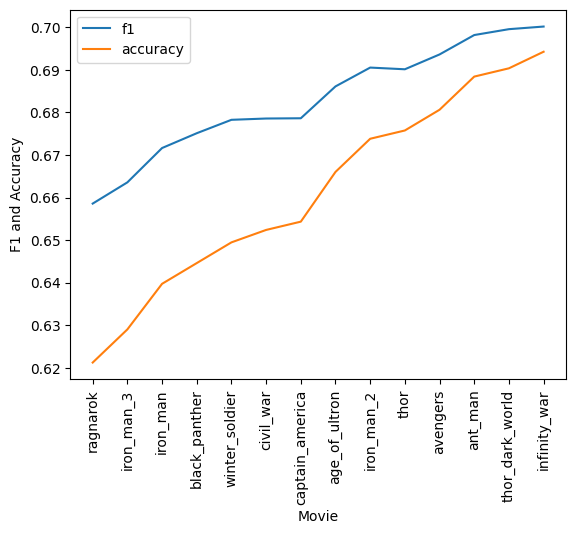

In [81]:

# plot the f1 and acc as lines for each movie
plt.plot(movie_names, f1_s, label='f1')
plt.plot(movie_names, acc_s, label='accuracy')
# put movie on x-axis
plt.xlabel('Movie')
plt.ylabel('F1 and Accuracy')
plt.xticks(rotation=90)

plt.legend()
plt.show()


100%|██████████| 65/65 [00:08<00:00,  7.43it/s]


Epoch 1, Loss: 0.8223339704366831


100%|██████████| 65/65 [00:08<00:00,  7.79it/s]


Loss: 0.8272906908622155
0.5107637294341679 0.6212268743914313
